In [17]:
!pip install torchviz

In [18]:
!pip install shap
!pip install lime

In [19]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import datetime
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc as sklearn_auc
import lime
import lime.lime_text
import shap
from torchviz import make_dot

# Setup logging
logging.basicConfig(filename='model_training.log', level=logging.INFO)



In [21]:
# Preprocessing and Tokenization
def preprocess_data(data):
    data['text'] = data['text'].apply(lambda x: x.lower())
    data['text'] = data['text'].str.replace('[^a-zA-Z\s]', '', regex=True)
    data['text'] = data['text'].str.replace(r'\s+', ' ', regex=True)
    return data

def tokenize_reviews(tokenizer, texts):
    return tokenizer(texts.tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')



In [22]:
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

# Regularization
def apply_regularization(model):
    for param in model.parameters():
        param.requires_grad = True
    return model



In [23]:
# Training function
def train_model(model, train_loader, optimizer, scheduler, criterion, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")



In [24]:
# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred_prob = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

            y_true.extend(labels)
            y_pred_prob.extend(predictions)

    return np.array(y_true), np.array(y_pred_prob)



In [25]:
# Cross-Validation
def k_fold_cross_validation(model, tokenizer, X, y, n_splits=5, num_epochs=1):
    kf = KFold(n_splits=n_splits)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        train_encodings = tokenize_reviews(tokenizer, X_train_fold)
        val_encodings = tokenize_reviews(tokenizer, X_val_fold)

        train_dataset = CustomDataset(
            train_encodings['input_ids'],
            train_encodings['attention_mask'],
            torch.tensor(y_train_fold.values, dtype=torch.long)
        )
        val_dataset = CustomDataset(
            val_encodings['input_ids'],
            val_encodings['attention_mask'],
            torch.tensor(y_val_fold.values, dtype=torch.long)
        )

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32)

        model = apply_regularization(model).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*num_epochs)
        criterion = torch.nn.CrossEntropyLoss()

        # Visualization of the model structure
        sample_input_ids = train_encodings['input_ids'][:1].to(device)
        sample_attention_mask = train_encodings['attention_mask'][:1].to(device)
        outputs = model(input_ids=sample_input_ids, attention_mask=sample_attention_mask).logits
        dot = make_dot(outputs, params=dict(model.named_parameters()))
        dot.format = 'png'
        dot.render('gpt_model_structure')

        # Display the image
        plt.imshow(plt.imread('gpt_model_structure.png'))
        plt.axis('off')
        plt.show()

        train_model(model, train_loader, optimizer, scheduler, criterion, num_epochs, device)
        y_true, y_pred_prob = evaluate_model(model, val_loader, device)
        print_metrics(y_true, y_pred_prob)



In [26]:
# Evaluation Metrics
def log_metrics(metrics):
    logging.info(metrics)

def print_metrics(y_true, y_pred_prob):
    if len(np.unique(y_true)) < 2:
        print("Only one class present in y_true. Skipping metrics calculation for this fold.")
        return

    accuracy = accuracy_score(y_true, y_pred_prob)
    precision = precision_score(y_true, y_pred_prob, zero_division=1)
    recall = recall_score(y_true, y_pred_prob, zero_division=1)
    f1 = f1_score(y_true, y_pred_prob, zero_division=1)
    auc_score = roc_auc_score(y_true, y_pred_prob)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score
    }
    log_metrics(metrics)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc_score}")

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = sklearn_auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Plot confusion matrix
    plot_confusion_matrix(confusion_matrix(y_true, y_pred_prob))

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')
    plt.show()



In [27]:
# Explainability
def explain_with_lime(model, tokenizer, X_test, num_samples=5):
    explainer = lime.lime_text.LimeTextExplainer(class_names=['negative', 'positive'])
    for i in range(num_samples):
        exp = explainer.explain_instance(X_test.iloc[i], lambda x: model(tokenizer(x, return_tensors='pt').to(device)).logits.cpu().detach().numpy(), num_features=10)
        exp.show_in_notebook()

def explain_with_shap(model, tokenizer, X_test, num_samples=5):
    explainer = shap.Explainer(lambda x: model(tokenizer(x, return_tensors='pt').to(device)).logits.cpu().detach().numpy())
    shap_values = explainer(X_test.iloc[:num_samples])
    shap.summary_plot(shap_values, X_test.iloc[:num_samples])



In [28]:
# Robustness and Reliability
def adversarial_testing(model, tokenizer, X_test, y_test, epsilon=0.1):
    adv_X_test = X_test.apply(lambda x: x + epsilon * ''.join(np.random.choice(list('abcdefghijklmnopqrstuvwxyz '), len(x))), axis=1)
    adv_encodings = tokenize_reviews(tokenizer, adv_X_test)
    adv_dataset = CustomDataset(
        adv_encodings['input_ids'],
        adv_encodings['attention_mask'],
        torch.tensor(y_test.values, dtype=torch.long)
    )
    adv_loader = DataLoader(adv_dataset, batch_size=32)
    y_true, y_pred_prob = evaluate_model(model, adv_loader, device)
    print("Adversarial Testing Results:")
    print_metrics(y_true, y_pred_prob)




In [29]:
# Model Saving and Loading
def save_model(model, model_name='bert_model.pth'):
    torch.save(model.state_dict(), model_name)
    print(f"Model saved to {model_name}")

def load_model(model_class, model_name='bert_model.pth'):
    model = model_class.from_pretrained('bert-base-uncased')
    model.load_state_dict(torch.load(model_name))
    return model

In [32]:
# Load and preprocess data
df = pd.read_csv('/content/drive/MyDrive/Training_Essay_Data00.csv', encoding='latin1')
df = preprocess_data(df)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)





/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
# Prepare data for cross-validation
X = df['text']
y = df['generated']


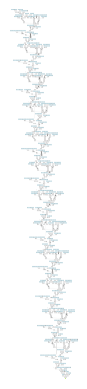

Epoch 1/3, Loss: 0.0694
Epoch 2/3, Loss: 0.0085
Epoch 3/3, Loss: 0.0020
Accuracy: 0.8749092229484386
Precision: 0.6969540526587507
Recall: 0.9297520661157025
F1 Score: 0.7966951903216287
AUC: 0.8925141001189951


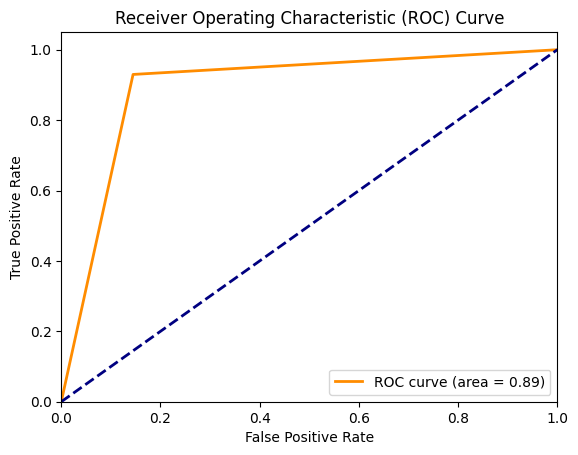

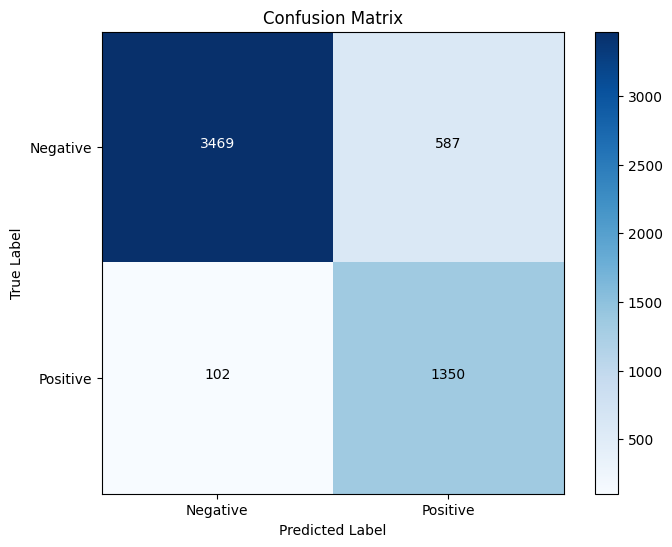

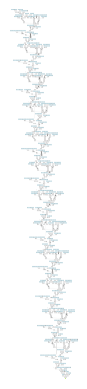

Epoch 1/3, Loss: 0.0117
Epoch 2/3, Loss: 0.0034
Epoch 3/3, Loss: 0.0003
Only one class present in y_true. Skipping metrics calculation for this fold.


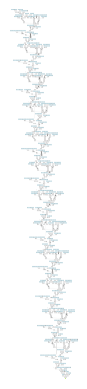

Epoch 1/3, Loss: 0.0037
Epoch 2/3, Loss: 0.0005
Epoch 3/3, Loss: 0.0000
Accuracy: 0.9943708007989831
Precision: 0.9679089026915114
Recall: 1.0
F1 Score: 0.9836927932667018
AUC: 0.9966097987751531


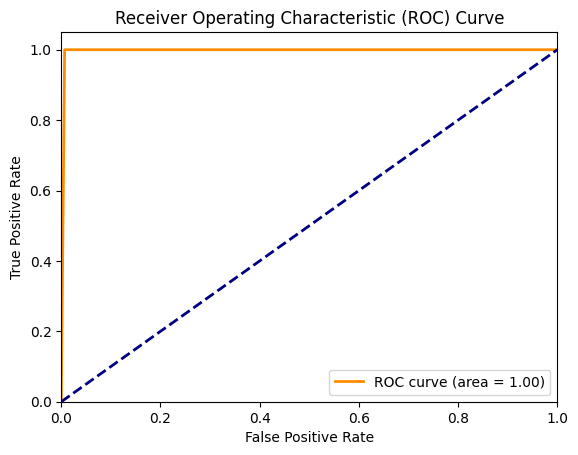

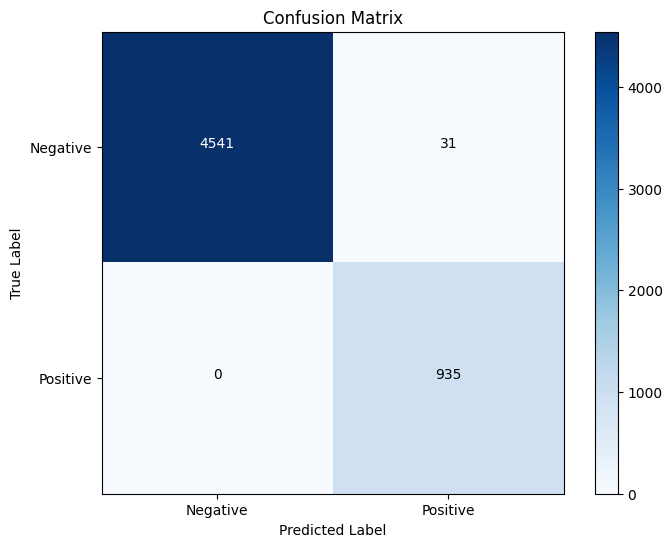

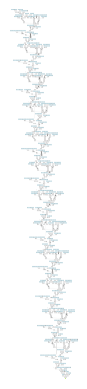

Epoch 1/3, Loss: 0.0044
Epoch 2/3, Loss: 0.0007
Epoch 3/3, Loss: 0.0000
Accuracy: 0.9998184129289994
Precision: 0.9997151808601538
Recall: 1.0
F1 Score: 0.9998575701467027
AUC: 0.999749624436655


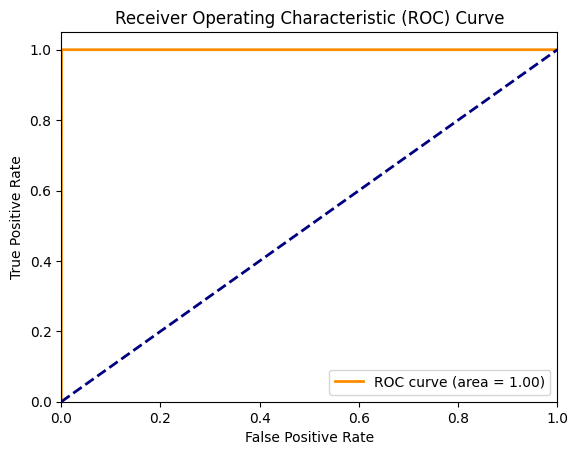

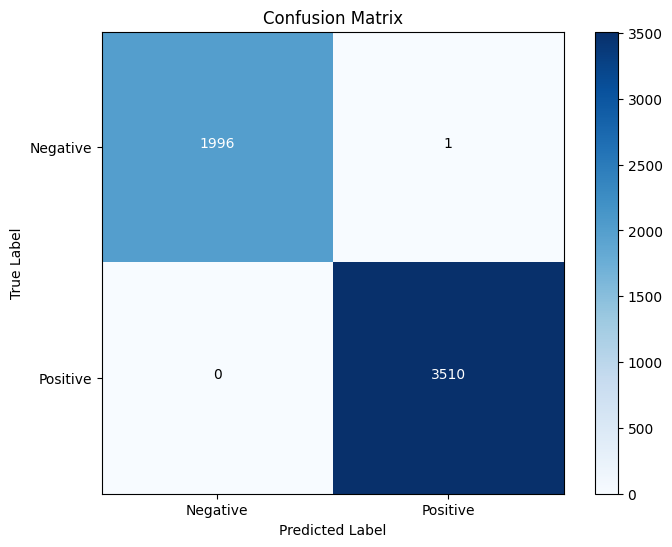

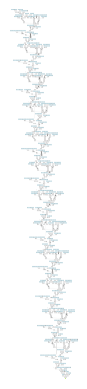

Epoch 1/3, Loss: 0.0025
Epoch 2/3, Loss: 0.0000


In [ ]:
# Perform k-fold cross-validation
k_fold_cross_validation(model, tokenizer, X, y, n_splits=5, num_epochs=3)


In [ ]:
# Model Saving and Loading
def save_model(model, model_name='bert_model.pth'):
    torch.save(model.state_dict(), model_name)
    print(f"Model saved to {model_name}")

def load_model(model_class, model_name='bert_model.pth'):
    model = model_class.from_pretrained('bert-base-uncased')
    model.load_state_dict(torch.load(model_name))
    return model


In [ ]:
# Save the trained model
save_model(model)


In [ ]:
!pip install onnx onnxruntime onnx-simplifier netron

In [ ]:
import torch
import torch.nn as nn
from transformers import GPT2ForSequenceClassification, GPT2Tokenizer
import onnx
import netron

In [ ]:
# Model Saving and Deployment
def save_model(model, path='model.pt'):
    torch.save(model.state_dict(), path)

In [ ]:
def deploy_model(path='model.pt'):
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

def export_model_to_onnx(model, example_input, filename):
    model.eval()
    torch.onnx.export(model, example_input, filename, verbose=True, input_names=['input_ids', 'attention_mask'], output_names=['output'])

def visualize_model_architecture(onnx_file):
    netron.start(onnx_file)  # Opens Netron for visualization



In [ ]:

# Save and visualize model
example_input = (torch.randint(0, 1000, (1, 128)), torch.ones((1, 128)))  # Dummy input
export_model_to_onnx(model, example_input, 'bert_model.onnx')
visualize_model_architecture('bert_model.onnx')
